In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup

In [91]:
plt.rcParams["figure.figsize"] = (20,10)
plt.style.use('ggplot')
pd.options.display.float_format= "{:.2f}".format

In [4]:
df = pd.read_csv("Walmart.csv")
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.57,211.10,8.11
1,1,12-02-2010,1641957.44,1,38.51,2.55,211.24,8.11
2,1,19-02-2010,1611968.17,0,39.93,2.51,211.29,8.11
3,1,26-02-2010,1409727.59,0,46.63,2.56,211.32,8.11
4,1,05-03-2010,1554806.68,0,46.50,2.62,211.35,8.11
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,4.00,192.01,8.68
6431,45,05-10-2012,733455.07,0,64.89,3.98,192.17,8.67
6432,45,12-10-2012,734464.36,0,54.47,4.00,192.33,8.67
6433,45,19-10-2012,718125.53,0,56.47,3.97,192.33,8.67


# Preprocess
* Based on a list of holiday, create a new column called ```Holiday_Event``` to map the the date of the holiday with the ```Date``` column of the data
* Convert ```Date``` column's data type from string to datetime
* Add ```Year``` and ```Month``` columns
* Sort the instances by date ascendingly
* Convert temperature's unit from Fahrenheit to Celsius

In [5]:
holiday_events = {
    'SuperBowl':['12-02-2010','11-02-2011','10-02-2012','08-02-2013'],
    'LabourDay':['10-09-2010','09-09-2011','07-09-2012','06-09-2013'],
    'Thanksgiving':['26-11-2010','25-11-2011','23-11-2012','29-11-2013'],
    'Christmas':['31-12-2010','30-12-2011','28-12-2012','27-12-2013']
    }

flatten_events = {val:key for key,lst in holiday_events.items() for val in lst}

df['Holiday_Event'] = df['Date'].map(flatten_events)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Temperature'] = (df['Temperature'] - 32 ) * (5/9)
df = df.sort_values(by='Date')
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Questions

## Q1. What should Walmart do to increase total sales in the next year?

### Get total sales of each store
* Based on the contribution of each store, we know which stores should be focus on optimizing the profit.

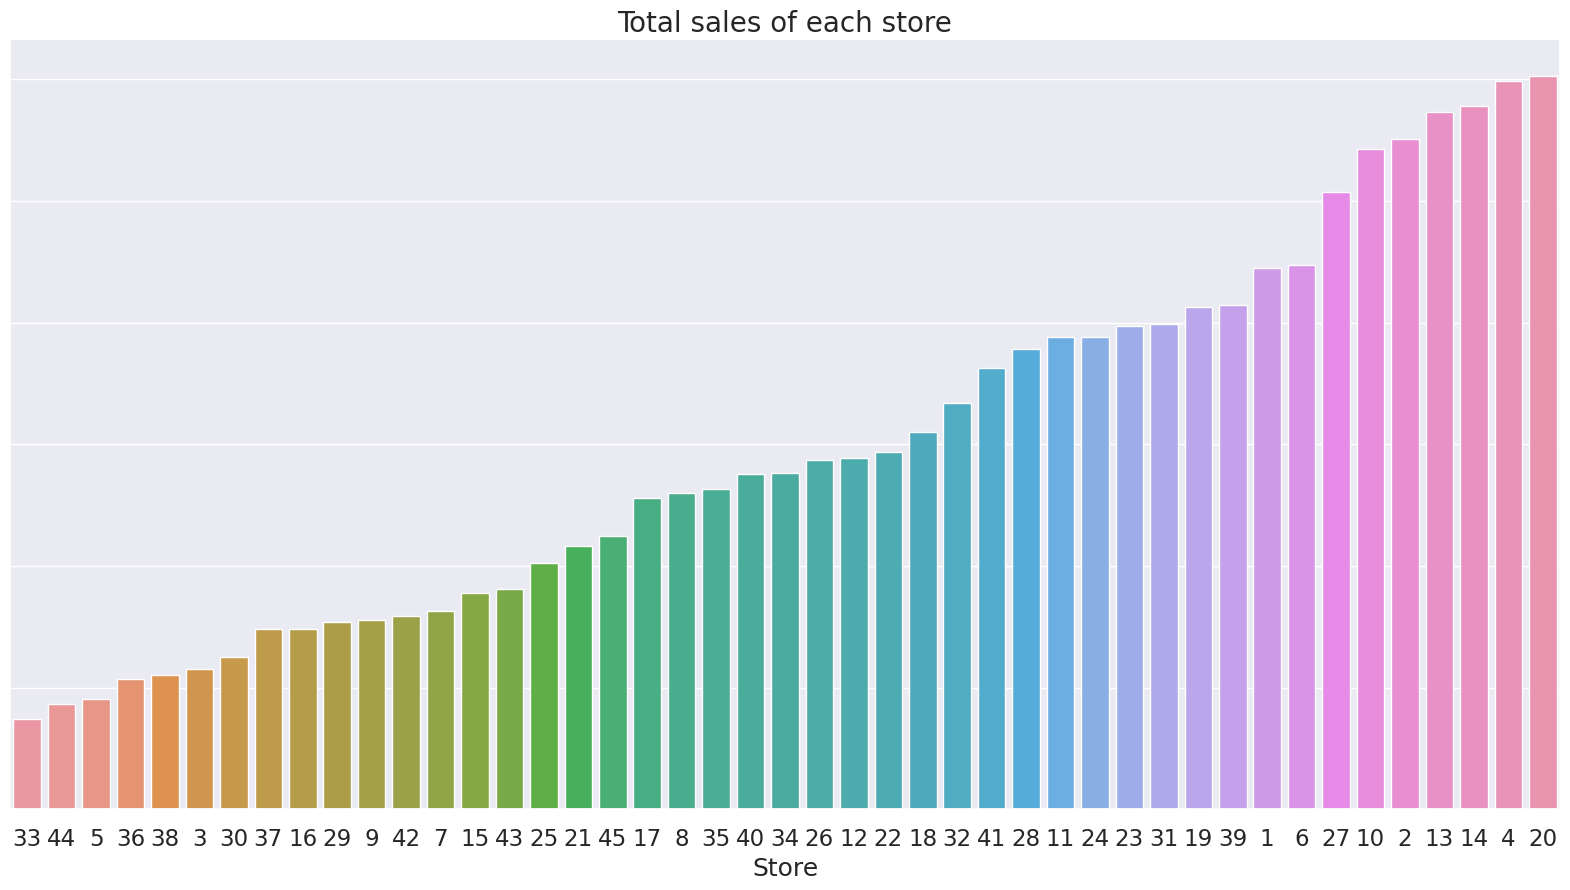

In [99]:
sales_by_store = df[['Store','Weekly_Sales']].groupby('Store').agg('sum').reset_index()
fig = sns.barplot(
    data=sales_by_store,x='Store',y='Weekly_Sales',
    order=sales_by_store.sort_values(by='Weekly_Sales')['Store'],);
sns.set(font_scale=2)
fig.set_title('Total sales of each store',fontsize=20);
fig.set_ylabel('')
fig.set_yticklabels([]);

### Top 3 lowest sales stores
* We tend to increase the profit of the stores with the least contribution
* Let us have a look at how they contributed to the total sales.

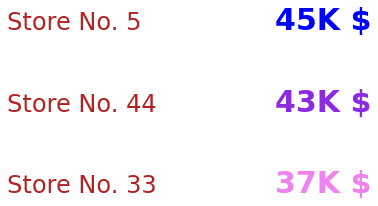

In [86]:
top3_lowest = sales_by_store.sort_values(by='Weekly_Sales').head(3)

fig , ax = plt.subplots(1,1,figsize = (6, 3))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.set_facecolor('white')
ax.tick_params(axis='both',length=0)

for s in ['top','right','left','bottom']:
    ax.spines[s].set_visible(False)

ax.text(0,0,f'Store No. {top3_lowest.iloc[0,0]}',fontsize=24,color='firebrick')
ax.text(0.8,0,'{:.0f}K $'.format(round(top3_lowest.iloc[0,1]/1e6)),fontsize=30, fontweight='bold', color='violet')
ax.text(0,0.5,f'Store No. {top3_lowest.iloc[1,0]}',fontsize=24,color='firebrick')
ax.text(0.8,0.5,'{:.0f}K $'.format(round(top3_lowest.iloc[1,1]/1e6)),fontsize=30,  fontweight='bold', color='blueviolet')
ax.text(0,1,f'Store No. {top3_lowest.iloc[2,0]}',fontsize=24,color='firebrick')
ax.text(0.8,1,'{:.0f}K $'.format(round(top3_lowest.iloc[2,1]/1e6)),fontsize=30, fontweight='bold', color='blue');

### Comment
* These 3 stores has extremely small amount of contributions. It could be the stores are located in rural areas, where the population is low and the terrain is hard to travel, or the weather condition is too harsh.
* So we should have some kind of methods to reduce the expense for goods transportation, in case the stores are located in places with harsh terrains.

# Cutting down the expense
* We propose a method that should be used to reduce the business expense on transportation based on the fuel price trend in the most recent year

### Fuel price trend
* How did the fuel price change in the last year?
* What should Walmart do to reduce transportation expense?

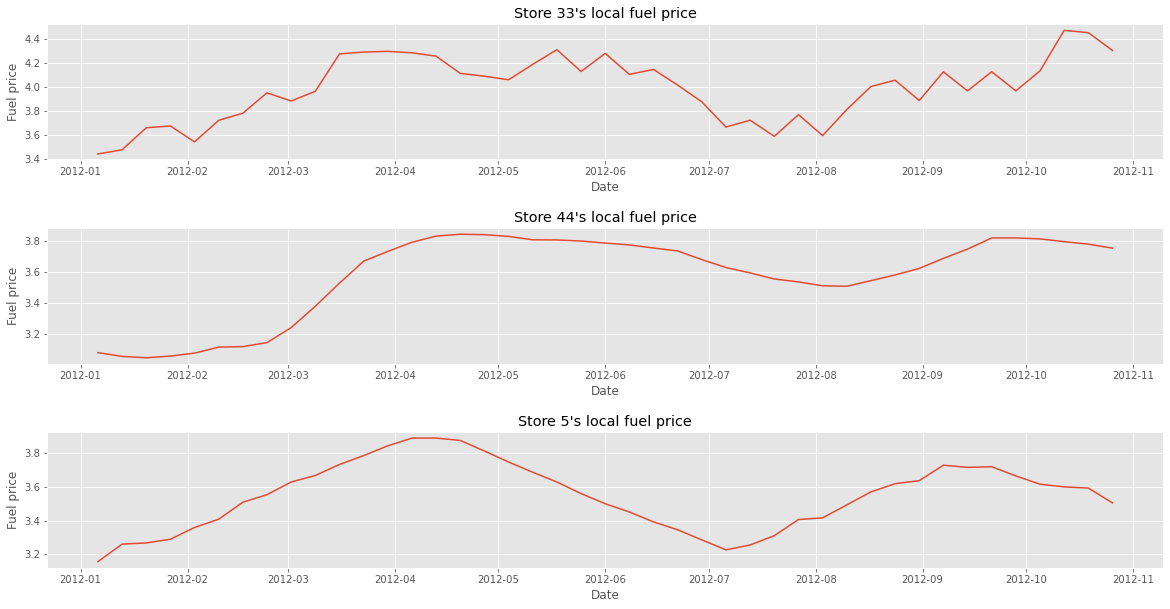

In [14]:
latest_year = df['Year'].max()

fig, axes = plt.subplots(3,1)

plt.subplots_adjust(hspace=0.5)
for i in range(top3_lowest['Store'].shape[0]):
    store_no = top3_lowest['Store'].iloc[i]
    data = df[(df['Store'] == store_no) & (df['Year'] == latest_year)]
    axes[i].plot(data['Date'],data['Fuel_Price'])
    axes[i].set_title(f"Store {store_no}'s local fuel price")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Fuel price')

### Comment
* We can see that the fuel price changes dramatically in 2012, and we anticipated that the trend should be similar in the next year. 
* In that case, Walmart should plan on ```transporting their goods``` to these stores when the fuel prices would be dropped.
* Beside during the early of the year (```January``` to ```March```), there are some periods of year that the fuel price also dropped:
    * ```Store no.5```: the cost of fuel dropped ```significantly``` during ```June``` and ```August```
    * ```Store no.44```: the cost of fuel dropped slightly between ```July``` and ```September```
    * ```Store no.33```: the fuel price would be changes dramatically in short periods. In general, the price would be reduced during ```July```

# Prioritizing products
* A proposal about prioritizing goods for certain stores based on their local environments

### Local temperature (latest year)
* We use the data about temperature to predict what kind of product these stores should focus on to increase profit.
* Unlike fuel price, the weather is predicted to be more and more extreme in the next few years, so we anticipated that the temperature would also be more extreme in the next year.

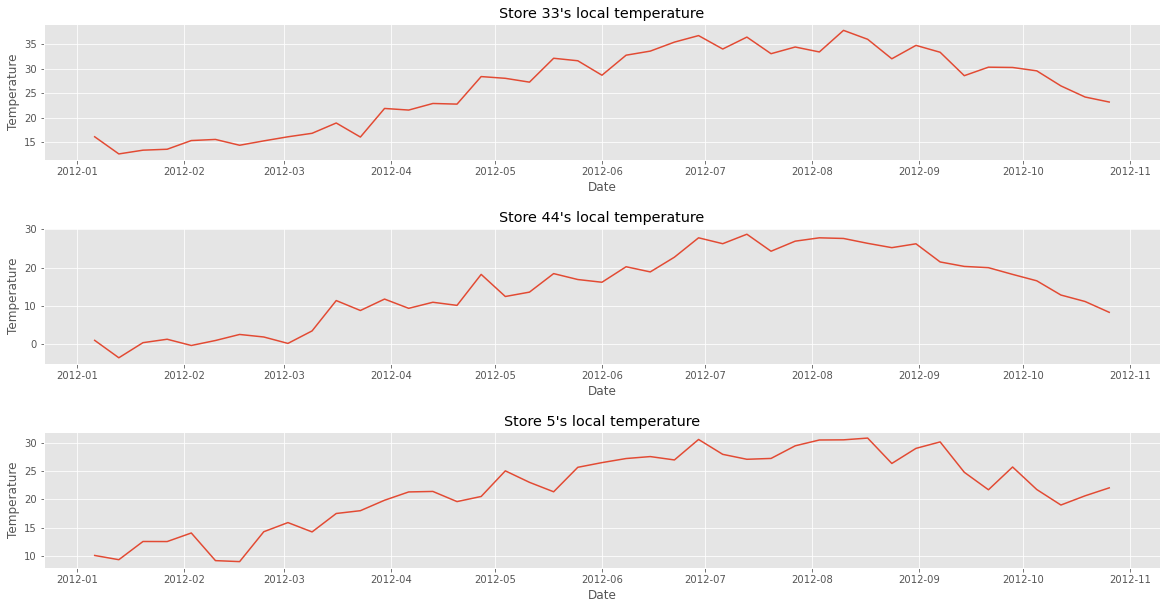

In [15]:
fig, axes = plt.subplots(3,1)

plt.subplots_adjust(hspace=0.5)
for i in range(top3_lowest['Store'].shape[0]):
    store_no = top3_lowest['Store'].iloc[i]
    data = df[(df['Store'] == store_no) & (df['Year'] == latest_year)]
    axes[i].plot(data['Date'],data['Temperature'])
    axes[i].set_title(f"Store {store_no}'s local temperature")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Temperature')

### Comment
* In general, the temperature trends were the same for the analyzed stores. 
* The type of product that should be prioritize for each store as followed:
    * ```Store no.5```: clothes, heater,etc for winter
    * ```Store no.44```: Since the temperature could be below 0 during winter, food, winter related products should be prioritized.
    * ```Store no.33```: The weather would be high during ```July``` and ```September```, products like air-conditioner, refrigrator,drinks would increase the profit.